# 전체적인 머신러닝 프로젝트 과정(6/7~6/21)

1. 문제 정의
    - 문제 정의
    - 분석 데이터 정의
    - 머신러닝 문제 정의
    - 베이스라인 선정
2. 데이터 수집 및 정제
    - 데이터 정합성 평가
    - 데이터 취합
    - 데이터 포맷 통일
3. EDA
    - 결측치, 이상치 처리
    - 데이터 시각화
    - 통계량 분석
4. feature engineering
    - 차원 문제
    - 상관관계
    - 범주형 변수 인코딩
5. 예측 모델 개발 및 적용
    - 예측 모델 학습 및 개선
    - 성능평가
    - 최종 모델 배포

# 20220607 Todo list
1. baseline을 잡기 위해 rough하게 모델링
    - 데이터 살펴보고 object type columns(4개) drop하고 모델링 진행함
2. target value인 winPlacePerc와의 상관관계 파악 후 0에 가까운 columns 팀원분들과 상의 후 drop


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore')

## columns 설명

- Id - 플레이어의 Id
- groupId - 경기 내의 그룹을 식별하는 ID. 현재 그룹의 선수들이 서로 다른 경기에서 경기한다면, 그들은 매번 다른 groupId를 갖게 될 것이다.
- matchId - 경기를 식별하기 위한 ID. train set과 test set에 모두 있는 시합은 없다.
- matchDuration - 경기 시간.
- matchType - 경기 종류(duo, quad ...).
- assists - 팀 동료들과 같이 죽인 적 수이다.
- boosts - 부스트 아이템 사용한 수.
- damageDealt - 가한 데미지 총량. Note: 자신에게 가한 데미지는 제외.
- DBNOs - 빈사상태로 만든 적의 수.
- headshotKills - 헤드샷 으로 처리한 적의 수.
- heals - 치료 아이템 사용 수.
- killPlace - 경기에서 처치한 적의 수 랭킹.
- killPoints - 플레이어의 처치 기반 외부 랭킹 (Elo 방식의 순위). rankPoints에서 -1이 아닌 값이 있는 경우, 
- killPoints에서 0은 "없음"으로 처리되어야 한다.
- kills - 처치한 적의 수.
- killStreaks - 단기간에 가장 많이 처치한 적의 최대치.
- longestKill - 플레이어가 적을 죽인 가장 긴 거리. 선수를 다운시키고 멀리 운전하는 것이 가장 긴 처치로 이어질 수 있기 때문에 오해의 소지가 있을 수 있다.
- maxPlace - 경기에서 가장 순위가 낮은 것에 대한 데이터. 이것은 순위를 건너뛸 수도 있기 때문에 numGroups와 일치하지 않을 수 있다.
- numGroups - 경기에 있는 팀의 수.
- rankPoints - Elo 방식의 플레이어 랭킹. 다음 버전의 API에서는 삭제될 예정이기 때문에 사용에 주의. '-1' 값은 순위가 "None" 이다.
- revives - 플레이어가 팀원 회복 시킨 수.
- rideDistance - 차량으로 이동한 거리(단위 : 미터).
- roadKills - 차량으로 죽인 플레이어 수.
- swimDistance - 수영한 거리(단위 : 미터).
- teamKills - 팀킬한 횟수.
- vehicleDestroys - 차량을 폭파시킨 횟수.
- walkDistance - 걸은 총 거리(단위 : 미터).
- weaponsAcquired - 무기 얻은 갯수.
- winPoints - 플레이어의 승리 기반 외부 랭킹 (Elo 방식의 순위). rankPoints에서 -1이 아닌 값이 있는 경우, 
- winPoints에서 0은 "없음"으로 처리되어야 한다.
- winPlacePerc - 예측 목표. 순위의 퍼센트로 표시되며, 1이면 경기에서 1등이고 0이면 경기에서 꼴지 했다는 것이다. 이것은 numGroups로 계산되는게 아니라, maxPlace로 계산되기 때문에 누락되는 것이 있을수도다

In [2]:
# Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    #start_mem = df.memory_usage().sum() / 1024**2
    #print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    #end_mem = df.memory_usage().sum() / 1024**2
    #print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    #print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [3]:
base_path='/content/drive/MyDrive/이어드림스쿨/Project/ML_project/PUBG_ML_team_project/pubg-finish-placement-prediction/'

In [4]:
train = pd.read_csv(base_path + 'train_V2.csv')
train = reduce_mem_usage(train)

In [5]:
train.shape

(4446966, 29)

## 1. baseline을 잡기 위해 rough하게 모델링
데이터 살펴보고 object type columns(4개) drop하고 모델링 진행함

In [6]:
display(train.head(2))
display(train.tail(2))

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.0,0,0,0,60,...,0,0.000000,0,0.000000,0,0,244.75,1,1466,0.444336
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.5,0,0,0,57,...,0,0.004501,0,11.039062,0,0,1434.00,5,0,0.640137


,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
4446964,cc032cdd73b7ac,c2223f35411394,c9c701d0ad758a,0,4,180.375,1,1,2,11,...,2,0.0,0,0.0,0,0,2748.0,8,0,0.799805
4446965,0d8e7ed728b6fd,8c74f72fedf5ff,62a16aabcc095c,0,2,268.000,0,0,1,18,...,0,1369.0,0,0.0,0,0,1244.0,5,0,0.546387


In [7]:
train.isna().sum() # winPlacePerc 1개 결측치 drop
train = train.dropna()
train.isna().sum()

Id                 0
groupId            0
matchId            0
assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
matchDuration      0
matchType          0
maxPlace           0
numGroups          0
rankPoints         0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPoints          0
winPlacePerc       0
dtype: int64

In [8]:
# 기초통계량 확인
pd.options.display.float_format = '{:.3f}'.format
train.describe()

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
count,4446965.000,4446965.000,4446965.000,4446965.000,4446965.000,4446965.000,4446965.000,4446965.000,4446965.000,4446965.000,...,4446965.000,4446965.000,4446965.000,4446965.000,4446965.000,4446965.000,4446965.000,4446965.000,4446965.000,4446965.000
mean,0.234,1.107,NaN,0.658,0.227,1.370,47.599,505.006,0.925,0.544,...,0.165,NaN,0.003,NaN,0.024,0.008,NaN,3.660,606.460,NaN
std,0.589,1.716,NaN,1.146,0.602,2.680,27.463,627.505,1.558,0.711,...,0.472,NaN,0.073,NaN,0.167,0.093,NaN,2.457,739.700,0.000
min,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,0.000,0.000,0.000,0.000,0.000,0.000,24.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,155.125,2.000,0.000,0.200
50%,0.000,0.000,84.250,0.000,0.000,0.000,47.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,685.500,3.000,0.000,0.458
75%,0.000,2.000,186.000,1.000,0.000,2.000,71.000,1172.000,1.000,1.000,...,0.000,0.191,0.000,0.000,0.000,0.000,1976.000,5.000,1495.000,0.741
max,22.000,33.000,6616.000,53.000,64.000,80.000,101.000,2170.000,72.000,20.000,...,39.000,40704.000,18.000,3824.000,12.000,5.000,25776.000,236.000,2013.000,1.000


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4446965 entries, 0 to 4446965
Data columns (total 29 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Id               object 
 1   groupId          object 
 2   matchId          object 
 3   assists          int8   
 4   boosts           int8   
 5   damageDealt      float16
 6   DBNOs            int8   
 7   headshotKills    int8   
 8   heals            int8   
 9   killPlace        int8   
 10  killPoints       int16  
 11  kills            int8   
 12  killStreaks      int8   
 13  longestKill      float16
 14  matchDuration    int16  
 15  matchType        object 
 16  maxPlace         int8   
 17  numGroups        int8   
 18  rankPoints       int16  
 19  revives          int8   
 20  rideDistance     float16
 21  roadKills        int8   
 22  swimDistance     float16
 23  teamKills        int8   
 24  vehicleDestroys  int8   
 25  walkDistance     float16
 26  weaponsAcquired  int16  
 27  winPoints   

In [10]:
# baseline을 잡기 위해 rough하게 모델링 -> object type columns(4개) drop
data = train.drop(columns=['Id', 'groupId', 'matchId', 'matchType'], axis=1)

In [11]:
data.head(2)

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,0,0,0.000,0,0,0,60,1241,0,0,...,0,0.000,0,0.000,0,0,244.750,1,1466,0.444
1,0,0,91.500,0,0,0,57,0,0,0,...,0,0.005,0,11.039,0,0,1434.000,5,0,0.640


In [12]:
# train, test split
from sklearn.model_selection import train_test_split

X = data.drop(columns='winPlacePerc')
y = data['winPlacePerc']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3557572, 24), (889393, 24), (3557572,), (889393,))

In [13]:
# ML model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from xgboost.sklearn import XGBRegressor
from lightgbm.sklearn import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

from sklearn.metrics import mean_absolute_error

In [14]:
# LinearRegression

model_lr = LinearRegression().fit(X_train, y_train)
pred = model_lr.predict(X_test)
mae = mean_absolute_error(pred, y_test)
print('LinearRegression MAE : %f' %mae)

LinearRegression MAE : 0.092592


In [15]:
# Lasso

model_ls = Lasso().fit(X_train, y_train)
pred2 = model_ls.predict(X_test)
mae = mean_absolute_error(pred2, y_test)
print('Lasso MAE : %f' %mae)

Lasso MAE : 0.120861


In [16]:
# Ridge

model_rg = Ridge().fit(X_train, y_train)
pred3 = model_rg.predict(X_test)
mae = mean_absolute_error(pred3, y_test)
print('Ridge MAE : %f' %mae)

Ridge MAE : 0.092592


In [17]:
# LGBMRegressor

model_lgb = LGBMRegressor().fit(X_train, y_train)
pred4 = model_lgb.predict(X_test)
mae = mean_absolute_error(pred4, y_test)
print('LGBMRegressor MAE : %f' %mae)

LGBMRegressor MAE : 0.060401


In [18]:
# XGBRegressor

model_xgb = XGBRegressor().fit(X_train, y_train)
pred5 = model_xgb.predict(X_test)
mae = mean_absolute_error(pred5, y_test)
print('XGBRegressor MAE : %f' %mae)

[16:17:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor MAE : 0.069529


In [19]:
# # RandomForestRegressor

# model_rfr = RandomForestRegressor().fit(X_train, y_train)
# pred6 = model_rfr.predict(X_test)
# mae = mean_absolute_error(pred6, y_test)
# print('RandomForestRegressor MAE : %f' %mae)

In [20]:
# # SVR

# model_svr = SVR().fit(X_train, y_train)
# pred7 = model_rfr.predict(X_test)
# mae = mean_absolute_error(pred7, y_test)
# print('SVR MAE : %f' %mae)

- LinearRegression MAE : 0.092592
- Lasso MAE : 0.120861
- Ridge MAE : 0.092592
- LGBMRegressor MAE : 0.060401
- XGBRegressor MAE : 0.069529

## 2. target value인 winPlacePerc와의 상관관계 파악 후 0에 가까운 columns 확인


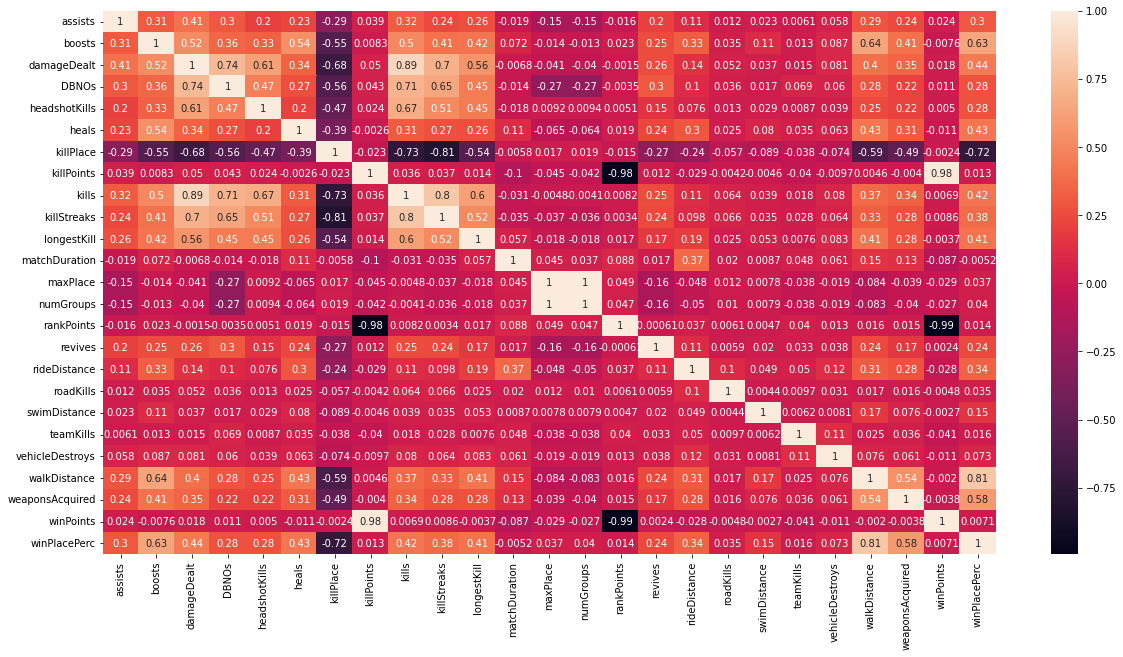

In [27]:
plt.figure(figsize=(20,10))
sns.heatmap(data=train.corr(), annot=True)
plt.show()

KillPoints, matchDuration, maxPlace, numGroups, rankPoints, roadKills, teamKills, vehicleDestroys, winPoints<br>

columns의 특성 파악 + 다른 columns사이의 상관관계가 높으면 다중공선성 문제 발생을 고려하여 <br>팀원들과 상의 후  'matchDuration', 'rankPoints', 'roadKills', 'teamKills' 4개 columns drop으로 결정

# 20220607 Todo list conclusion
1. baseline을 잡기 위해 rough하게 모델링
    - 데이터 살펴보고 object type columns(4개) drop하고 모델링 진행함
        - LinearRegression MAE : 0.092592
        - Lasso MAE : 0.120861
        - Ridge MAE : 0.092592
        - LGBMRegressor MAE : 0.060401
        - XGBRegressor MAE : 0.069529

2. target value인 winPlacePerc와의 상관관계 파악 후 0에 가까운 columns 상의 후 drop
    - 결론 : 팀원들과 상의해본 결과 'matchDuration', 'rankPoints', 'roadKills', 'teamKills' 4개 columns drop으로 결정